# ML-Ensemble using the House Prices competition data
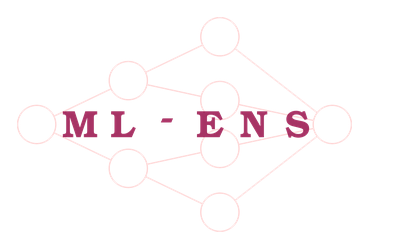

> *ML-Ensemble a Python library for memory efficient parallelized ensemble learning. In particular, ML-Ensemble is a Scikit-learn compatible library for building deep ensemble networks in just a few lines of code.*

This notebook is adapted from part of the extensive [Getting started tutorial](http://ml-ensemble.com/info/tutorials/start.html) on the [ML-Ensemble website](http://ml-ensemble.com/).

For the ensemble meta learners we shall use [XGBoost](https://github.com/dmlc/xgboost), [CatBoost](https://github.com/catboost/catboost), and the [Regularized Greedy Forest (RGF)](https://github.com/RGF-team/rgf/tree/master/python-package) (See my notebook ["Introduction to the Regularized Greedy Forest"](https://www.kaggle.com/carlmcbrideellis/introduction-to-the-regularized-greedy-forest) for more details).
For the meta estimator we shall use the [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

### Install both ML-Ensemble (`mlens`) and the Regularized Greedy Forest (`rgf_python`):

In [ ]:
!pip install mlens
!pip install rgf_python

### set up the House Prices competition data

In [ ]:
import pandas  as pd
import numpy   as np

#===========================================================================
# read in the data
#===========================================================================
train_data = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test_data  = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

#===========================================================================
# select some features of interest
#===========================================================================
features = ['OverallQual' , 'GrLivArea' , 'TotalBsmtSF' , 'BsmtFinSF1' ,
            '2ndFlrSF'    , 'GarageArea', '1stFlrSF'    , 'YearBuilt'  ]

#===========================================================================
#===========================================================================
X_train       = train_data[features]
y_train       = train_data["SalePrice"]
X_test        = test_data[features]

#===========================================================================
# imputation; substitute any 'NaN' with mean value
#===========================================================================
X_train      = X_train.fillna(X_train.mean())
X_test       = X_test.fillna(X_test.mean())

### create a House Prices scoring function
The House Prices competition uses the root of the [mean squared logarithmic error regression loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html) (Note: Be sure to adapt this function to the needs of your particular dataset/competition)

In [ ]:
from sklearn.metrics import mean_squared_log_error

def RMSLE(y,y_hat):
    return np.sqrt( mean_squared_log_error(y,y_hat) )

### build and run the ensemble

In [ ]:
from mlens.ensemble import SuperLearner
from rgf.sklearn import RGFRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# --- Build ---
# Passing a scoring function will create cv scores during fitting
# the scorer should be a simple function accepting to vectors and returning a scalar
ensemble = SuperLearner(scorer=RMSLE, verbose=2)

# Build the first layer
ensemble.add([xgb.XGBRegressor(n_estimators  = 750,learning_rate = 0.02, max_depth = 4),
              CatBoostRegressor(loss_function='RMSE', verbose=False),
              RGFRegressor(max_leaf=300, algorithm="RGF_Sib", test_interval=100, loss="LS")])


# Attach the final meta estimator
ensemble.add_meta(RandomForestRegressor())

# --- Use ---

# Fit ensemble
ensemble.fit(X_train, y_train)

# Predict
predictions = ensemble.predict(X_test)

In [ ]:
print("Fit data:\n%r" % ensemble.data)

### now write out the `submission.csv` file:

In [ ]:
output = pd.DataFrame({"Id":test_data.Id, "SalePrice":predictions})
output.to_csv('submission.csv', index=False)

Here we have looked at the ensembling, however the final score can  be improved upon with better feature selection (see for example ["Feature selection using Boruta-SHAP"](https://www.kaggle.com/carlmcbrideellis/feature-selection-using-borutashap)) as well as both feature engineering, and hyperparameter tuning of the individual estimators. The ensembling its-self is not so much about producing a better score (although this can happen) but about reducing the variance (or increasing the [explained variance score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html)). Indeed our result may not beat the score of the best individual estimator that we used in the ensemble. However, what it can do is reduce the overfitting that leads to unwelcome surprises during the competition shakeup.

In [ ]:
import matplotlib.pyplot as plt
from mlens.visualization import exp_var_plot
from sklearn.decomposition import PCA
exp_var_plot(X_train, PCA(), marker='s', where='post');

# Links
* [ML-Ensemble](http://ml-ensemble.com/)
* [GitHub: mlens](https://github.com/flennerhag/mlens) 

# Related notebooks
* [ML-Ensemble: Scikit-learn style ensemble learning ](https://www.kaggle.com/flennerhag/ml-ensemble-scikit-learn-style-ensemble-learning) by [flnr](https://www.kaggle.com/flennerhag) (the author of `mlens`)
* [Ensemble learning lib: MLens [99% accuracy]](https://www.kaggle.com/vipulgote4/ensemble-learning-lib-mlens-99-accuracy) by [vipul](https://www.kaggle.com/vipulgote4)